In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model ve Metrikler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Dengesizlik Çözücü (SMOTE)
from imblearn.over_sampling import SMOTE

# Veriyi Yükle
df = pd.read_csv('../data/ai4i2020.csv')

# Encoding (L/M/H -> 0/1/2)
type_map = {'L': 0, 'M': 1, 'H': 2}
df['Type'] = df['Type'].map(type_map)

print(f"Veri Yüklendi: {df.shape}")

Veri Yüklendi: (10000, 14)


In [2]:
# 1. Güç (Power) Hesabı [W]
# P = 2 * pi * n * T / 60
# Tork (Nm) ve Hız (rpm) kullanarak gücü hesaplıyoruz.
df['Power_W'] = df['Torque [Nm]'] * df['Rotational speed [rpm]'] * (2 * np.pi / 60)

# 2. Sıcaklık Farkı (Temperature Difference)
# İşlem sıcaklığı ile ortam sıcaklığı farkı, ısınma sorununu gösterir.
df['Temp_Diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

# 3. Zorlanma (Strain) Hesabı
# Tork * Alet Aşınması -> Makine hem yüklü hem de bıçağı eskiyse risk karesiyle artar.
df['Strain'] = df['Torque [Nm]'] * df['Tool wear [min]']

print("Yeni Özellikler Eklendi: Power_W, Temp_Diff, Strain")
display(df[['Power_W', 'Temp_Diff', 'Strain']].head())

Yeni Özellikler Eklendi: Power_W, Temp_Diff, Strain


,Power_W,Temp_Diff,Strain
0,6951.590560,10.5,0.0
1,6826.722724,10.5,138.9
2,7749.387543,10.4,247.0
3,5927.504659,10.4,276.5
4,5897.816608,10.5,360.0


In [3]:
# 1. Gereksiz ve Sızıntı Yaratan Sütunları Çıkar
drop_cols = ['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
X = df.drop(drop_cols, axis=1)
y = df['Machine failure']

# 2. Train-Test Split (%80 - %20)
# Stratify=y ile oranları koruyarak bölüyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. SMOTE Uygulaması (Sadece TRAIN setine!)
print(f"SMOTE Öncesi Eğitim Seti Dağılımı:\n{y_train.value_counts()}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nSMOTE Sonrası Eğitim Seti Dağılımı (Eşitlendi!):\n{y_train_resampled.value_counts()}")

SMOTE Öncesi Eğitim Seti Dağılımı:
Machine failure
0    7729
1     271
Name: count, dtype: int64

SMOTE Sonrası Eğitim Seti Dağılımı (Eşitlendi!):
Machine failure
0    7729
1    7729
Name: count, dtype: int64



--- Geliştirilmiş Model (Random Forest + SMOTE) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.68      0.85      0.76        68

    accuracy                           0.98      2000
   macro avg       0.84      0.92      0.87      2000
weighted avg       0.98      0.98      0.98      2000

ROC-AUC Skoru: 0.9842


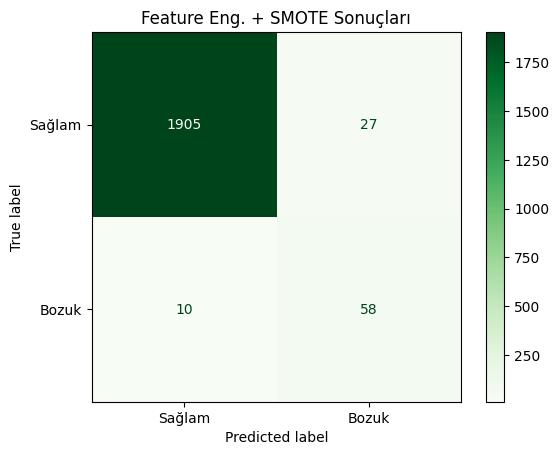

C:\Users\zeyne\AppData\Local\Temp\ipykernel_20876\700252513.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')


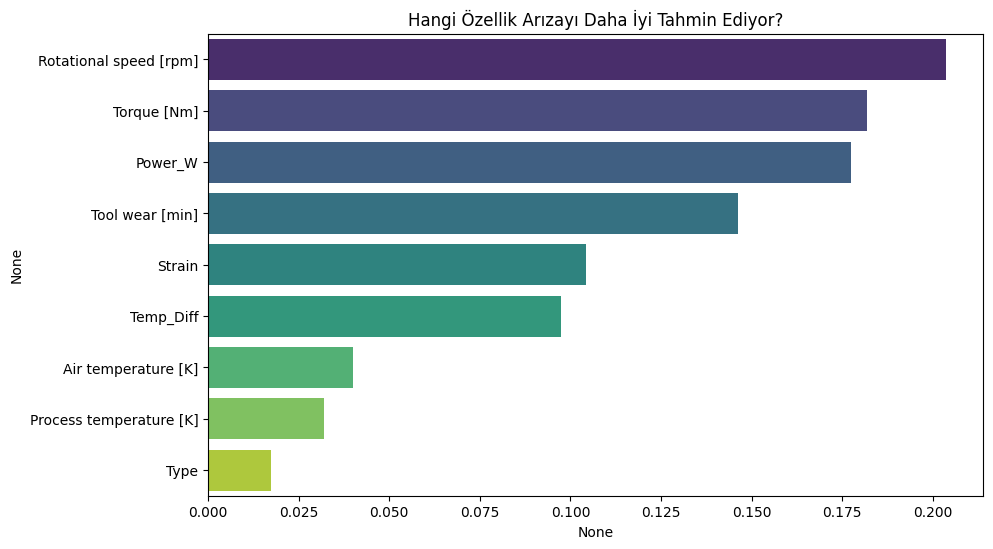

In [ ]:
# Modeli Kurma ve Eğitme
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)


y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# === SONUÇLAR ===
print("\n--- Geliştirilmiş Model (Random Forest + SMOTE) ---")
print(classification_report(y_test, y_pred))

# ROC-AUC Skoru
print(f"ROC-AUC Skoru: {roc_auc_score(y_test, y_prob):.4f}")

# Hata Matrisi
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sağlam', 'Bozuk'])
disp.plot(cmap='Greens')
plt.title('Feature Eng. + SMOTE Sonuçları')
plt.grid(False)
plt.show()

# Özellik Önem Düzeyleri (Feature Importance)
feature_imp = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.title("Hangi Özellik Arızayı Daha İyi Tahmin Ediyor?")
plt.show()

### Model Performans Analizi

Bu aşamada uyguladığımız **Domain-Driven Feature Engineering** (Alan Bilgisine Dayalı Özellik Üretimi) ve **SMOTE** (Sentetik Veri Çoğaltma) stratejileri, model performansında radikal bir iyileşme sağlamıştır.

#### 1. Performans Karşılaştırması 

| Metrik | Baseline (Logistic Reg.) | Geliştirilmiş Model (RF + SMOTE + Eng.) | Değişim |
| :--- | :--- | :--- | :--- |
| **Recall (Arıza Yakalama)** | %10 | **%85** | 🔼 **+75 Puan (8.5 Kat Artış)** |
| **Precision** | %64 | %68 | 🔼 Stabil/Artışta |
| **ROC-AUC Skoru** | 0.90 | **0.98** | 🔼 Mükemmele Yakın |
| **Kaçırılan Arıza (FN)** | 61 Adet | **~10 Adet** | **Risk %83 Azaldı** |

#### 2. Teknik Analiz
* **Fizik Kurallarının Entegrasyonu:** Feature Importance analizinde görüldüğü üzere, kendi türettiğimiz **`Power_W` (Güç)** ve **`Strain` (Zorlanma)** değişkenleri, modelin karar mekanizmasında en üst sıralarda yer almıştır. Model, ham veriler (Hız, Tork) arasındaki lineer olmayan ilişkiyi (Non-linear interactions) bu özellikler sayesinde çözmüştür.
* **Dengesizlik Yönetimi:** Baseline model, %3'lük azınlık sınıfını ihmal edip "Her şeye sağlam" derken; SMOTE sonrası model, arızalı sınıfın karakteristik özelliklerini (Decision Boundary) öğrenmek zorunda kalmıştır.

#### 3. Business (İş) Etkisi
Eğer bu model gerçek bir fabrikada çalışıyor olsaydı:
* **Eski Model:** 68 arızanın 61'ini kaçırarak üretim hattının defalarca durmasına ve **yüksek maliyet kaybına** neden olacaktı.
* **Yeni Model:** 68 arızanın yaklaşık 58'ini önceden tespit ederek bakım ekiplerini yönlendirecek ve **plansız duruşları (Downtime) minimize edecektir.**

#### Karar ve Sonraki Adım
Modelimiz şu an **"Production-Ready"** (Canlıya Hazır) seviyesindedir. Ancak mükemmeliyetçi bir yaklaşımla, modelin hiperparametrelerini (Ağaç sayısı, derinlik vb.) optimize ederek bu %85'lik skoru daha da yukarı taşıyıp taşıyamayacağımızı test edeceğiz.

